In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import plot_importance
import shap
import pickle
import json
from datetime import datetime

from pred_utils.pred_utils import rmsle_exp, cross_val_split
from data_prep.prepare_data import prepare_data

from configs.columns import essential_columns, macro_cols

import matplotlib.pyplot as plt

shap.initjs()

In [2]:
train_df = pd.read_csv("./data/train.csv", parse_dates=['timestamp'])
test_df = pd.read_csv("./data/test.csv", parse_dates=['timestamp'])
macro_df = pd.read_csv("./data/macro.csv", parse_dates=['timestamp'])

y_price = train_df.price_doc

train_df_processed, test_df_processed, Y_log1p = prepare_data(train_df, test_df, macro_df)

with open("./configs/good_features_06.txt", "r") as f:
    not_corr_other_columns = list(map(lambda x: x.replace("\n", ""), f.readlines()))

train_df_for_pred = train_df_processed[["timestamp_year_month"] + essential_columns + not_corr_other_columns + macro_cols]
test_df_for_pred = test_df_processed[["timestamp_year_month"] + essential_columns + not_corr_other_columns + macro_cols]

X = train_df_for_pred.copy()
del X["timestamp_year_month"]

X_test = test_df_for_pred.copy()
del X_test["timestamp_year_month"]

/home/andrey/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


---

In [3]:
model_name = "xgb_0.81_model_2019_05_06_15_19_5th"
model = pickle.load(open("./trained_models/" + model_name + ".dat", "rb"))

pred_test_log1p = model.predict(X_test)
pred_test = np.expm1(pred_test_log1p)

# pd.DataFrame(model.get_booster().get_score(importance_type='weight'), index=["Importance"]).T.sort_values(
#     "Importance", ascending=False)

---

In [4]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

Obseravtion 0


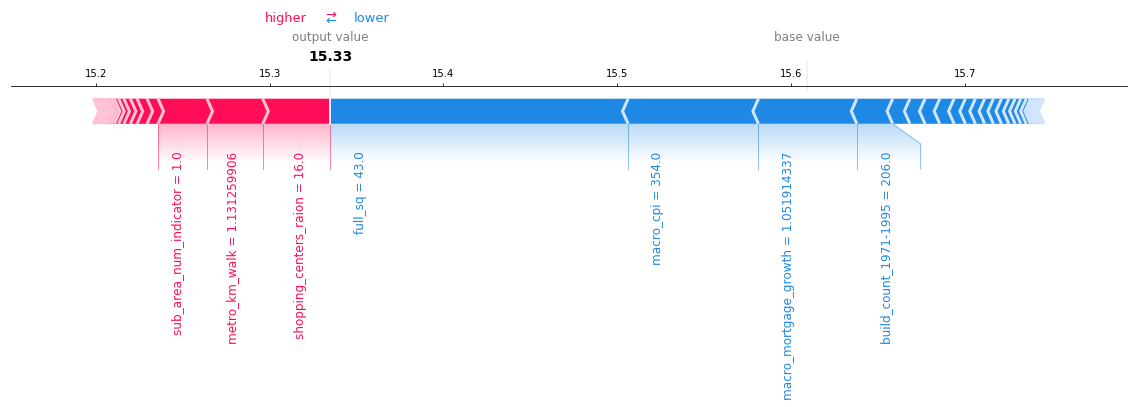

Obseravtion 1


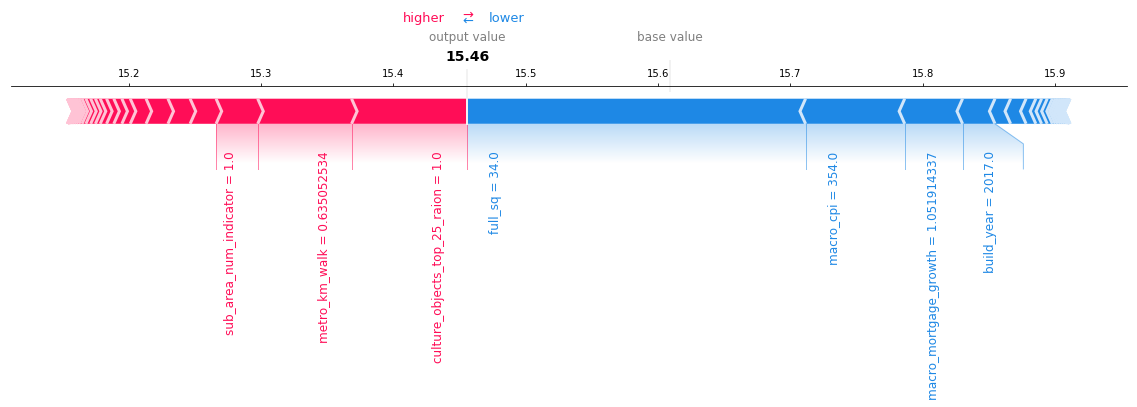

Obseravtion 2


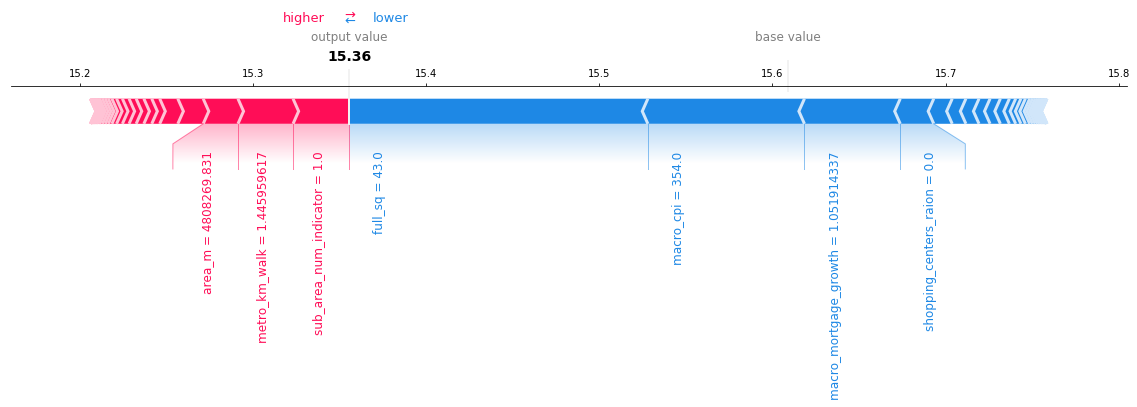

Obseravtion 3


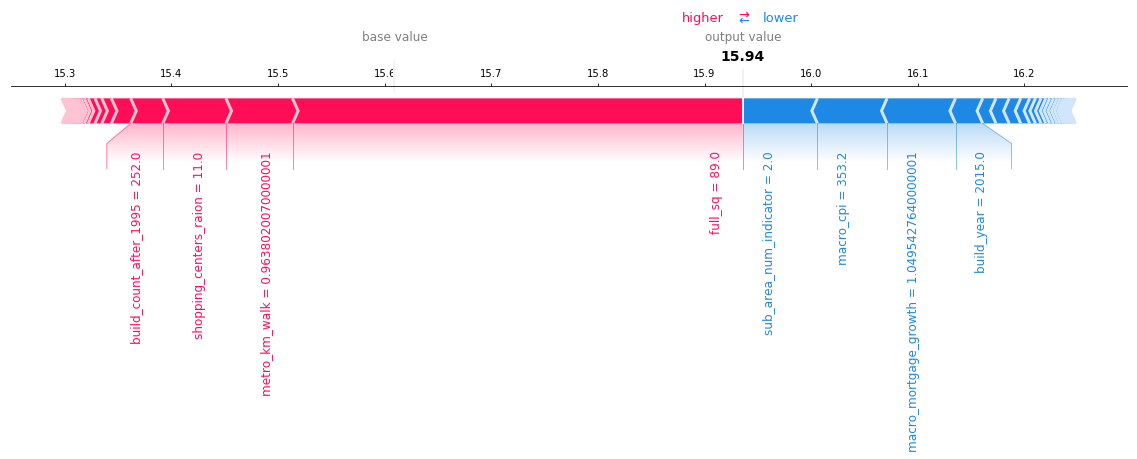

Obseravtion 50


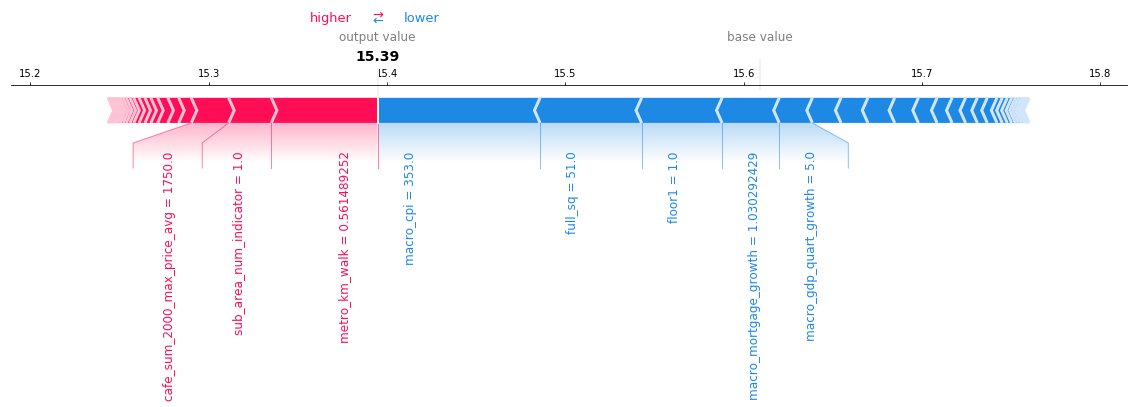

Obseravtion 100


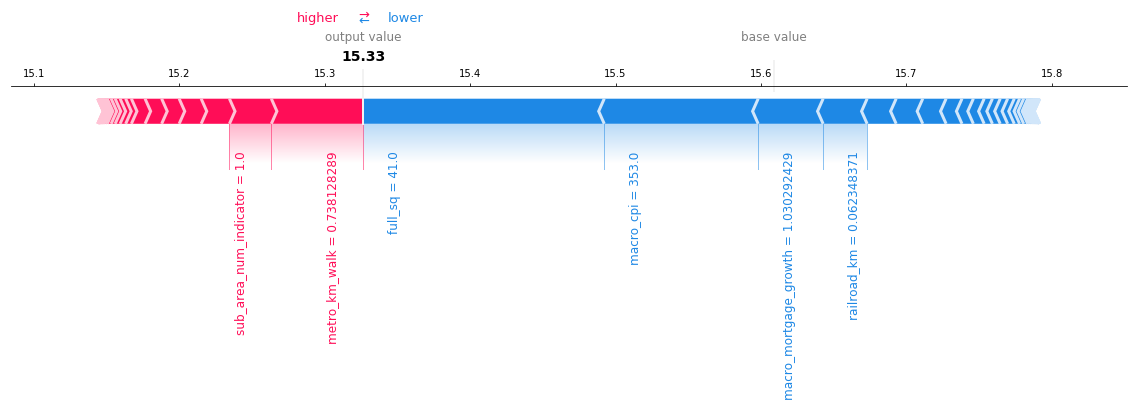

Obseravtion 500


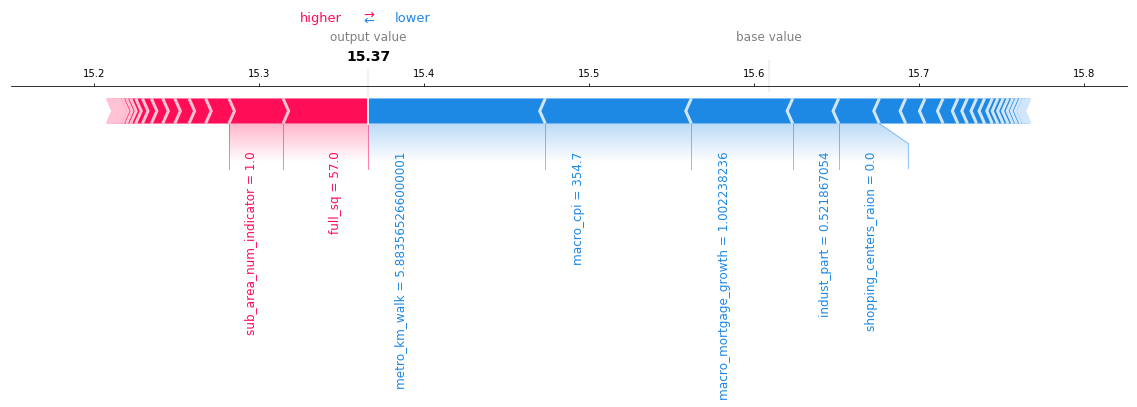

Obseravtion 1000


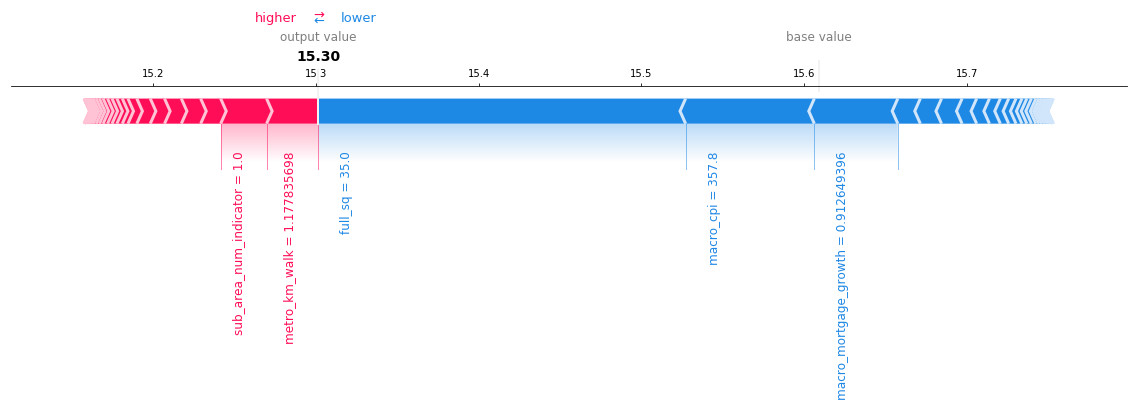

Obseravtion 1500


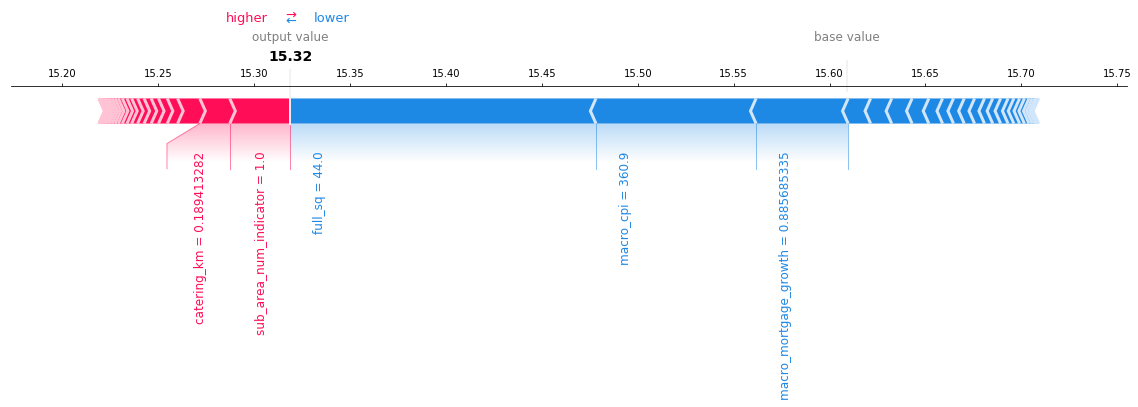

Obseravtion 2000


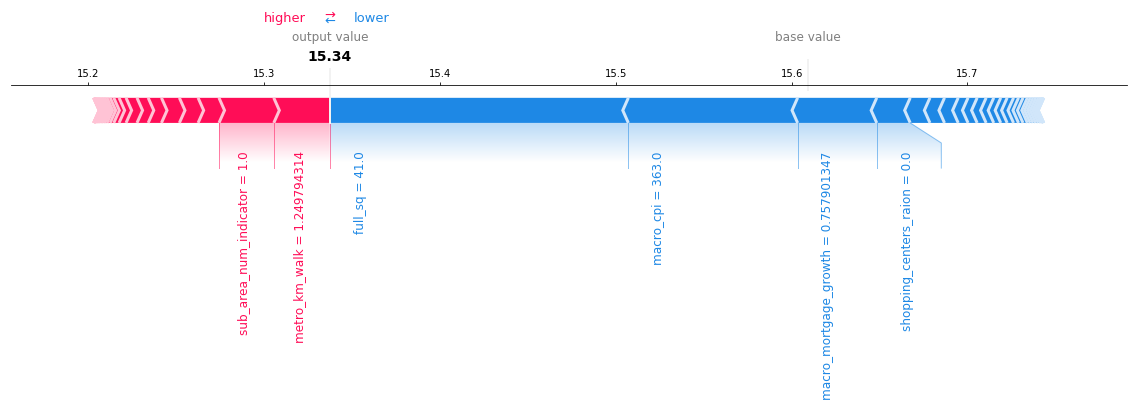

Obseravtion 2001


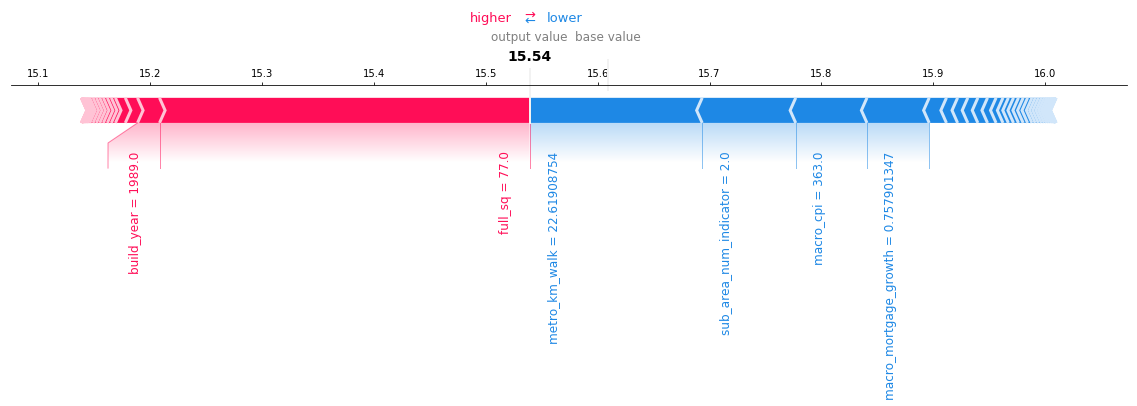

Obseravtion 2002


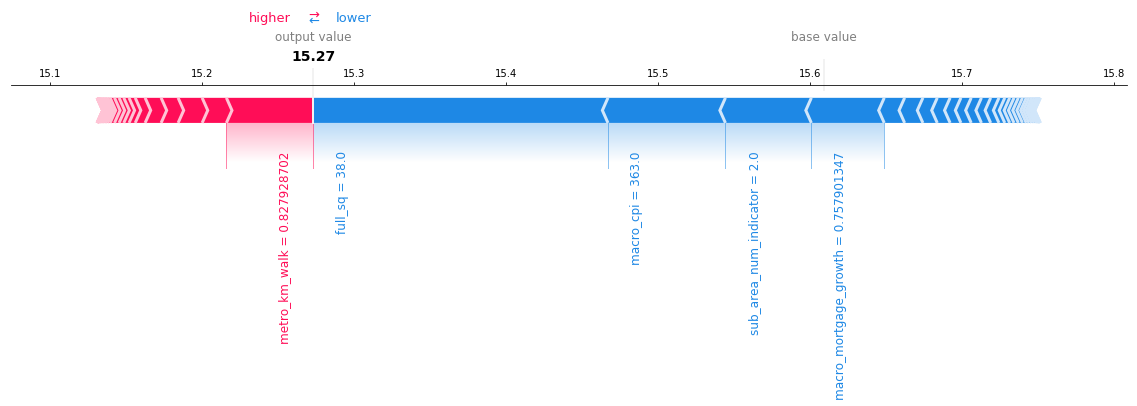

Obseravtion 2003


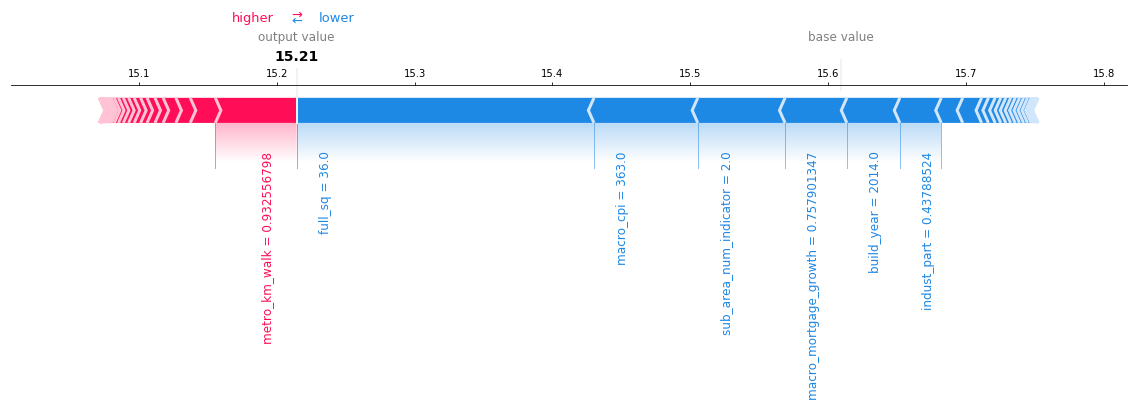

In [5]:
for i in [0,1,2,3,50,100,500,1000,1500,2000,2001,2002,2003]:
    print("Obseravtion", i)
    shap.force_plot(explainer.expected_value, shap_values[i,:], X.iloc[i,:], 
                    feature_names=None, 
                    out_names=None, link="identity",
                    plot_cmap="RdBu", 
                    matplotlib=True, show=True, 
                    figsize=(20,3), 
                    ordering_keys=None, ordering_keys_time_format=None,
                    text_rotation=90)

---

In [6]:
import seaborn as sns

color = sns.color_palette()
sns.set()

macro_mortgage_growth
full_sq
life_sq
kitch_sq
num_room
build_year
product_type_OwnerOccupier
sub_area_num_indicator
macro_mortgage_rate
macro_deposits_rate
macro_gdp_quart
macro_gdp_quart_growth
macro_oil_urals
macro_rts
macro_micex
macro_net_capital_export
macro_cpi


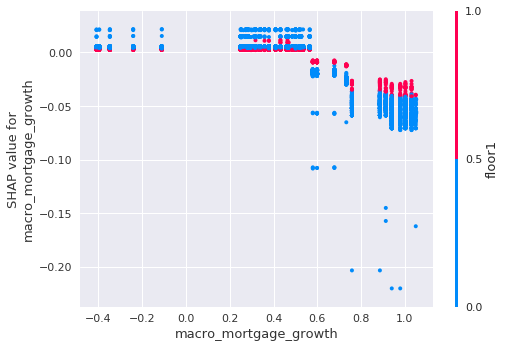

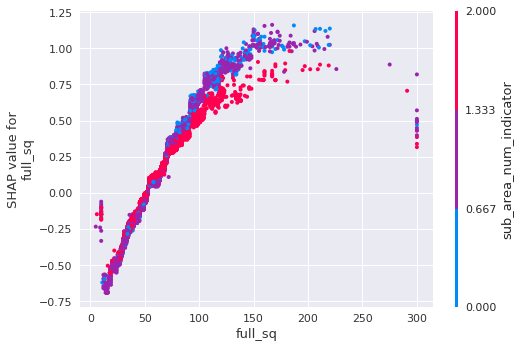

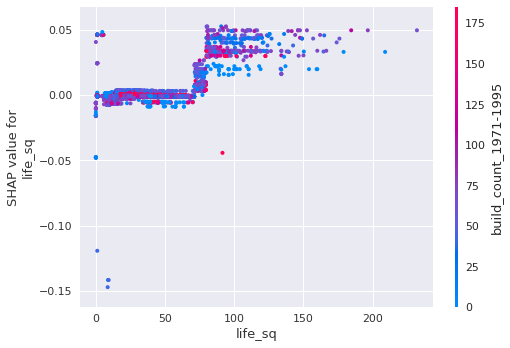

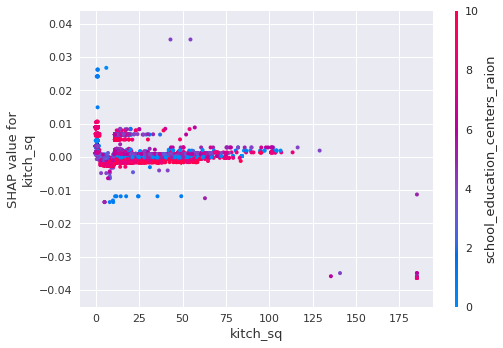

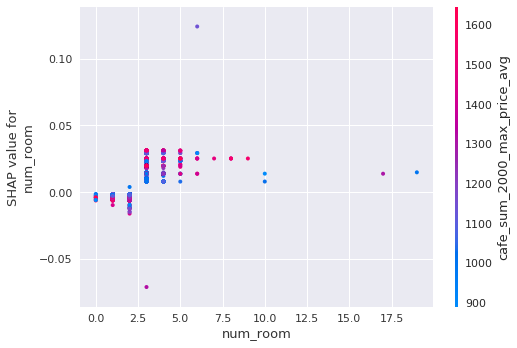

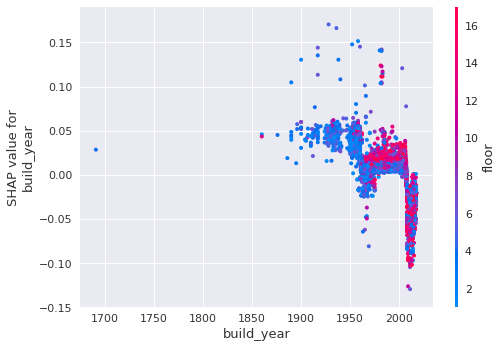

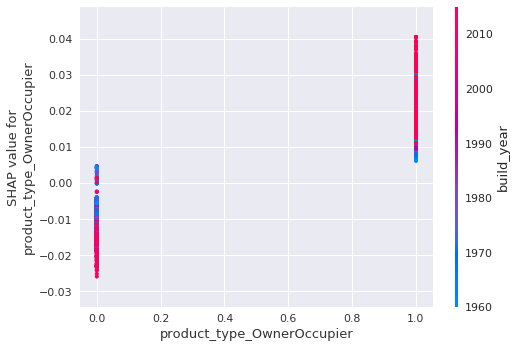

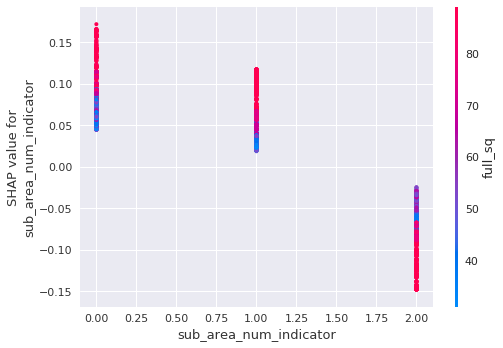

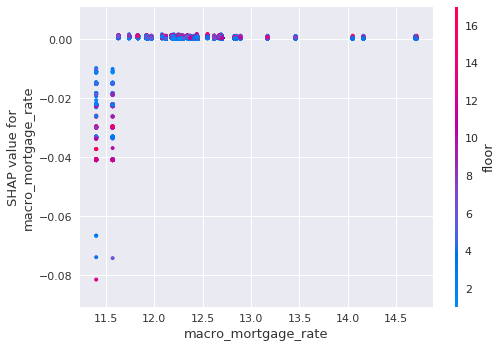

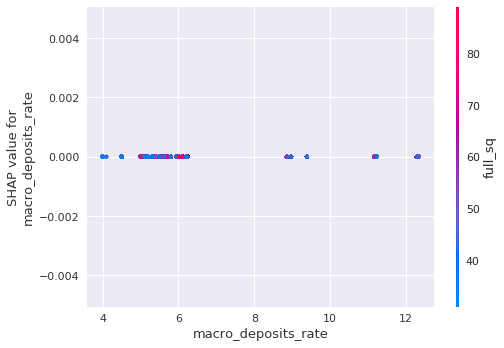

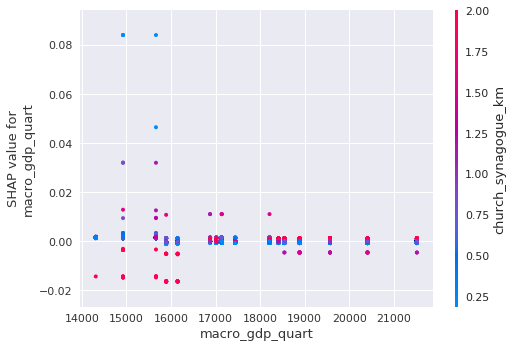

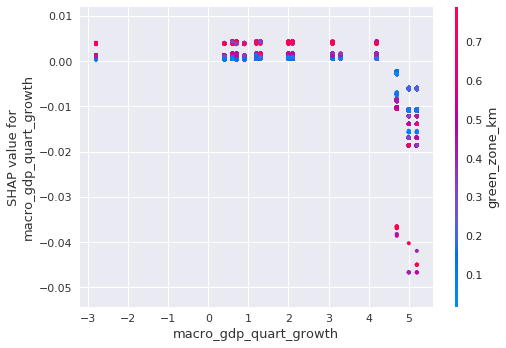

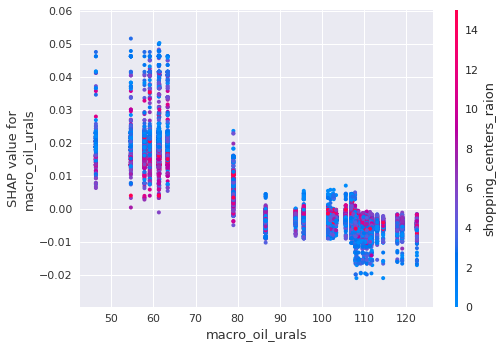

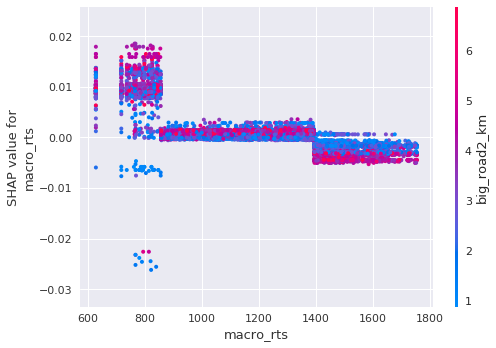

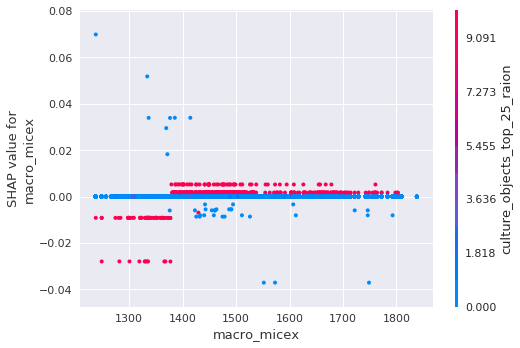

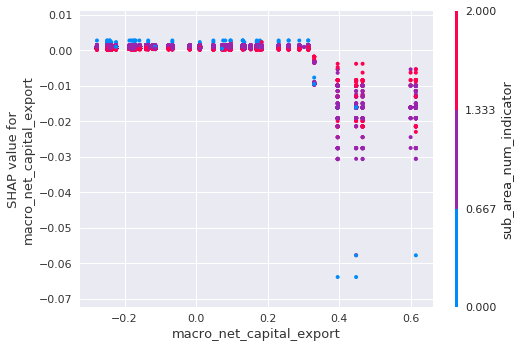

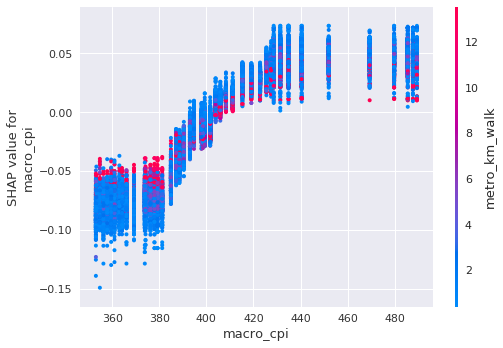

In [7]:
for f in ["macro_mortgage_growth",
          "full_sq", "life_sq", "kitch_sq", "num_room", "build_year", 
          "product_type_OwnerOccupier", "sub_area_num_indicator", 
          "macro_mortgage_rate", "macro_deposits_rate", "macro_gdp_quart", 
          "macro_gdp_quart_growth", "macro_oil_urals", "macro_rts", "macro_micex",
          "macro_net_capital_export", "macro_cpi"]:
    print(f)
    fig = plt.figure(figsize=(12,8), clear=True)
    shap.dependence_plot(f, shap_values, X, show=False)
    plt.tight_layout()
    fig.savefig("./imgs/shap/dependence_plot/{}_dependence_plot.png".format(f))

---

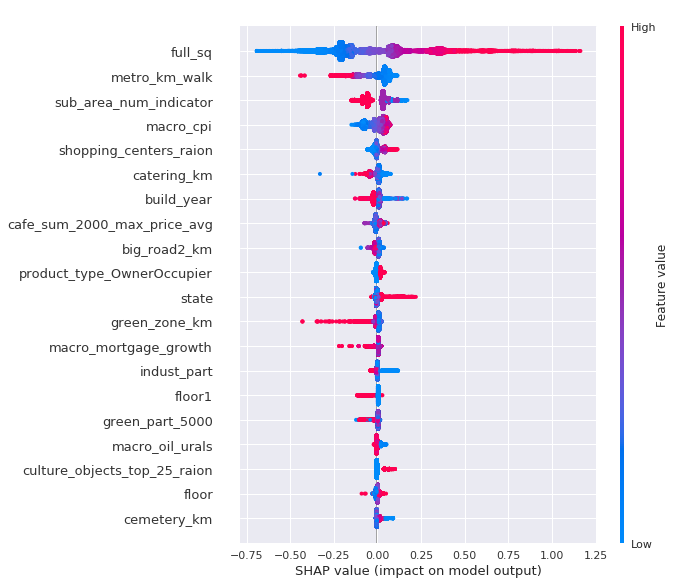

In [9]:
# fig = plt.figure(figsize=(12,8), clear=True)
shap.summary_plot(shap_values, X)
# plt.tight_layout()
# fig.savefig("./imgs/shap/summary_plot.png")

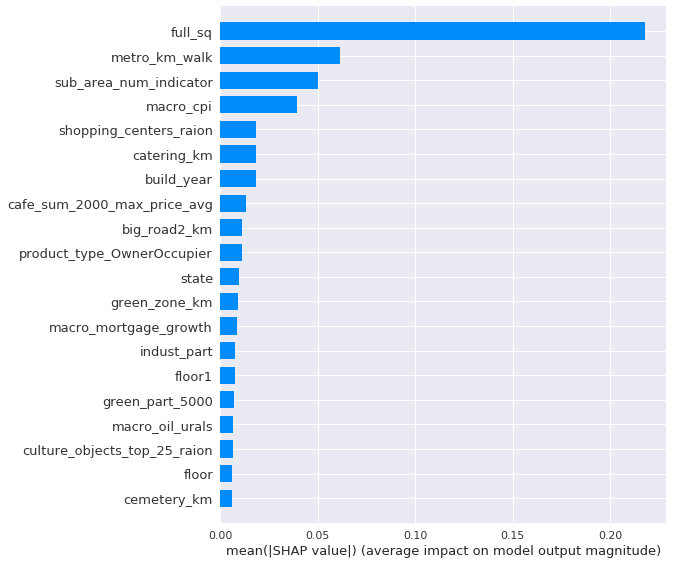

In [10]:
# fig = plt.figure(figsize=(12,8), clear=True)
shap.summary_plot(shap_values, X, plot_type="bar")
# plt.tight_layout()
# fig.savefig("./imgs/shap/summary_bar_plot.png")

---